In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/Trabajo Inteligencia Artificial/Notebooks/Dataset emociones/dataset_seis_emociones.csv'
df = pd.read_csv(file_path, low_memory=False)

In [ ]:
df.head(3)

,preprocessed_text,alegria,tristeza,ansiedad,ira,sorpresa,neutro,suma_emociones
0,game hurt,0,1,0,0,0,0,1
1,right nt care fuck em,0,0,0,0,0,1,1
2,man love reddit,1,0,0,0,0,0,1


In [ ]:
df.drop(columns = 'suma_emociones', inplace=True)

In [ ]:
df["preprocessed_text"][1]

'right nt care fuck em'

In [ ]:
print(f"\nEl dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")


El dataset tiene 606254 filas y 7 columnas.


In [ ]:
text_lengths = df['preprocessed_text'].str.len()
max_length = text_lengths.max()
max_length

685

In [ ]:
text_lengths = df['preprocessed_text'].str.len()
median_length = text_lengths.mean().round(2)
median_length

np.float64(53.04)

### Preparar los datos

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 1. Identificar columnas de texto y etiquetas
text_column = df.columns[0]
sentiment_columns = df.columns[1:]

texts = df[text_column].astype(str).tolist() # Convertir a lista de strings para el Tokenizer
labels = df[sentiment_columns].values # Obtener los valores de las etiquetas como un array NumPy

print(f"Número de textos: {len(texts)}")
print(f"Forma de las etiquetas (muestras, número_de_sentimientos): {labels.shape}")

Número de textos: 606254
Forma de las etiquetas (muestras, número_de_sentimientos): (606254, 6)


In [ ]:
# 2. Configuración del Tokenizer
vocab_size = 10000
oov_tok = "<unk>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(texts)

In [ ]:
# 3. Convertimos textos a secuencias de números
sequences = tokenizer.texts_to_sequences(texts)

# Mostrar un ejemplo de secuencia
print("\nEjemplo de texto original:", texts[0])
print("Ejemplo de secuencia numérica:", sequences[0])


Ejemplo de texto original: game hurt
Ejemplo de secuencia numérica: [133, 141]


In [ ]:
print("\nEjemplo de texto original:", texts[2])
print("Ejemplo de secuencia numérica:", sequences[2])


Ejemplo de texto original: man love reddit
Ejemplo de secuencia numérica: [120, 12, 842]


In [ ]:
# 4. Padding
# Necesitamos que todas las secuencias tengan la misma longitud para alimentar la red neuronal.
# maxlen: la longitud máxima de las secuencias.
#         Es común elegir la longitud del 90-95% de las secuencias o la longitud media + 2*desviación estándar.
#         Por ahora, calcularemos una longitud razonable basada en la distribución.
sequence_lengths = [len(s) for s in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 95)) # Usamos el percentil 95

print(f"\nLongitud máxima de secuencia (percentil 95): {max_sequence_length}")

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print("Forma de las secuencias acolchadas:", padded_sequences.shape)
print("Ejemplo de secuencia acolchada:", padded_sequences[0]) # Ahora todas tienen la misma longitud


Longitud máxima de secuencia (percentil 95): 18
Forma de las secuencias acolchadas: (606254, 18)
Ejemplo de secuencia acolchada: [133 141   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
# 5. Dividir el dataset en conjuntos de entrenamiento y prueba
test_size = 0.15    # se puede cambiar
random_state = 42  # aseguramos que la división se reproducible

print(f"\nDividiendo los datos en conjuntos de entrenamiento ({100-test_size*100}%) y prueba ({test_size*100}%)...")
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=test_size, random_state=random_state)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

print(f"Forma de X_train (entrenamiento): {X_train.shape}")
print(f"Forma de X_test (prueba): {X_test.shape}")
print(f"Forma de y_train (entrenamiento etiquetas): {y_train.shape}")
print(f"Forma de y_test (prueba etiquetas): {y_test.shape}")

print("\nPreprocesamiento de textos y preparación de datos completado.")


Dividiendo los datos en conjuntos de entrenamiento (85.0%) y prueba (15.0%)...
Forma de X_train (entrenamiento): (515315, 18)
Forma de X_test (prueba): (90939, 18)
Forma de y_train (entrenamiento etiquetas): (515315, 6)
Forma de y_test (prueba etiquetas): (90939, 6)

Preprocesamiento de textos y preparación de datos completado.


### Contrucción de la Red Neuronal con CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

embedding_dim = 100 # Dimensión de los vectores de palabra.

print(f"Número de clases de sentimiento: {labels.shape[1]}")
print(f"Tamaño del vocabulario (vocab_size): {vocab_size}")
print(f"Longitud máxima de secuencia (max_sequence_length): {max_sequence_length}")
print(f"Dimensión del embedding (embedding_dim): {embedding_dim}")

Número de clases de sentimiento: 6
Tamaño del vocabulario (vocab_size): 10000
Longitud máxima de secuencia (max_sequence_length): 18
Dimensión del embedding (embedding_dim): 100


In [ ]:
# 1. Creación el modelo Sequential
print("\nConstruyendo la arquitectura de la red neuronal (CNN)...")
model = Sequential()


Construyendo la arquitectura de la red neuronal (CNN)...


In [ ]:
# 2. Capa de Embedding
# Convierte los índices de palabras en vectores densos.
model.add(Embedding(input_dim=vocab_size + 1,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# 3. Capas Convolucionales 1D
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))

In [ ]:
# 4. Capa GlobalMaxPooling1D
model.add(GlobalMaxPooling1D())

In [ ]:
# 5. Capas Densa (Fully Connected)
# Estas capas densas procesan las características resumidas por la capa Max Pooling.
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.4))

In [ ]:
# 6. Capa de Salida
# units: Número de clases de sentimiento.
# activation: 'sigmoid' para clasificación multietiqueta.
model.add(Dense(units=6, activation='softmax'))

In [ ]:
# 7. Compilar el modelo
# optimizer: 'Adam'
# loss: 'binary_crossentropy' para clasificación multietiqueta.
# metrics: 'accuracy' para evaluación.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 8. Mostrar un resumen del modelo
print("\nResumen de la arquitectura del modelo (CNN):")
model.summary()


Resumen de la arquitectura del modelo (CNN):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # opcional

# Parámetros de entrenamiento
epochs = 10
batch_size = 64

print(f"Comenzando el entrenamiento del modelo por {epochs} épocas con un tamaño de batch de {batch_size}...")

Comenzando el entrenamiento del modelo por 10 épocas con un tamaño de batch de 64...


In [ ]:
# 1. EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               min_delta=0.0001,
                               mode='max',
                               restore_best_weights=True)

In [ ]:
# 2. ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando una métrica ha dejado de mejorar.
#    monitor: Métrica a monitorear.
#    factor: Factor por el que se reducirá la tasa de aprendizaje (new_lr = lr * factor).
#    patience: Número de épocas sin mejora después de las cuales se reducirá la tasa de aprendizaje.
#    min_lr: Límite inferior para la tasa de aprendizaje.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=0.00001)

In [ ]:
# Entrenar el modelo
history = model.fit(X_train_final, y_train_final,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

print("\nEntrenamiento del modelo completado.")

Epoch 1/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.7154 - loss: 0.7654 - val_accuracy: 0.7976 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 2/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7953 - loss: 0.5406 - val_accuracy: 0.7995 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 3/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8033 - loss: 0.5134 - val_accuracy: 0.8026 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 4/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8084 - loss: 0.4996 - val_accuracy: 0.8018 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 5/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8132 - loss: 0.4857 - val_accuracy: 0.8016 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 6/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8151 - loss: 0.4787 - val_accuracy: 0.8011 - val_loss: 0.5201 - learning_rate: 0.0010
Epoch 7/10
6845/6845 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8

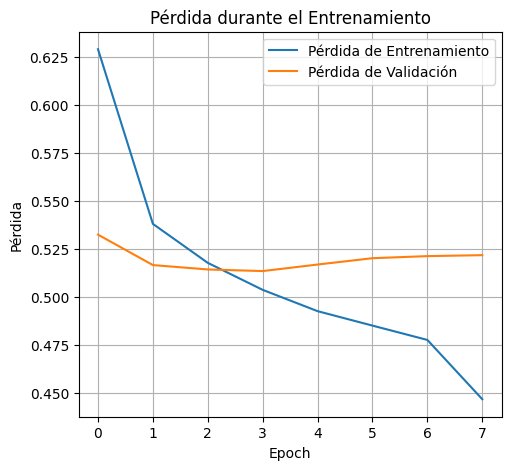

In [ ]:
# Gráfico de Pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

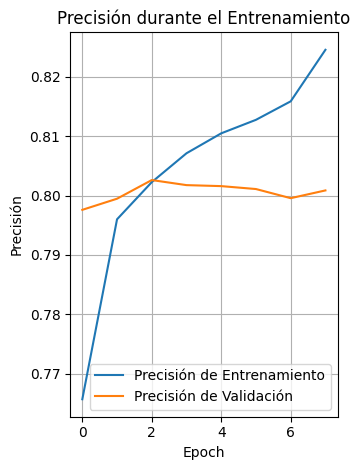

In [ ]:
# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 2. Evaluación final del modelo en el conjunto de prueba
print("\nEvaluando el modelo en el conjunto de prueba...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")


Evaluando el modelo en el conjunto de prueba...
Pérdida en el conjunto de prueba: 0.5131
Precisión en el conjunto de prueba: 0.8021


### Evaluación del model (Precisión, Recall, F1-Score)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import numpy as np

In [ ]:
# 1. Obtener las predicciones del modelo en el conjunto de prueba
y_pred_probs = model.predict(X_test)

2842/2842 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
# 2. Convertir probabilidades a la clase predicha (índice de la probabilidad más alta)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Para el cálculo de métricas de scikit-learn, y_test también necesita ser "des-one-hot" si estaba en ese formato.
# Es decir, convertir y_test de one-hot a índices de clase si es necesario.
# Si y_test ya es una sola columna de enteros (0 a 27), no necesitas este paso.
# Suponiendo que y_test sigue siendo un array one-hot (2D):
y_test_classes = np.argmax(y_test, axis=1) # <--- CAMBIO AQUÍ si y_test está en one-hot

print(f"Predicciones de clase generadas. Forma: {y_pred_classes.shape}")
print(f"Ejemplo de predicciones de clase (primeras 5): {y_pred_classes[:5]}")
print(f"Ejemplo de etiquetas reales de clase (primeras 5): {y_test_classes[:5]}")

Predicciones de clase generadas. Forma: (90939,)
Ejemplo de predicciones de clase (primeras 5): [0 3 5 0 0]
Ejemplo de etiquetas reales de clase (primeras 5): [0 3 1 2 0]


In [ ]:
# 3. Calcular Precision, Recall y F1-score para cada clase y promedios
precision, recall, f1_score, support = precision_recall_fscore_support(
    y_test_classes,
    y_pred_classes,
    average='weighted', # Opciones: 'micro', 'macro', 'weighted', None (para por clase)
    zero_division=0     # Para manejar casos donde una clase no tiene instancias verdaderas
)

print(f"\n--- Métricas Globales (Promedio Ponderado) ---")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Soporte Total: {np.sum(support)}")


--- Métricas Globales (Promedio Ponderado) ---
Precisión: 0.7921
Recall: 0.8021
F1-Score: 0.7906
Soporte Total: None


In [ ]:
# 4. Mostrar un reporte de clasificación detallado por clase
# Esto es muy útil para ver el rendimiento de cada sentimiento individualmente.
print(f"\n--- Reporte de Clasificación por Sentimiento ---")
print(classification_report(y_test_classes, y_pred_classes, target_names=sentiment_columns, zero_division=0))


--- Reporte de Clasificación por Sentimiento ---
              precision    recall  f1-score   support

     alegria       0.83      0.92      0.87     37082
    tristeza       0.88      0.86      0.87     22185
    ansiedad       0.84      0.77      0.80      8909
         ira       0.69      0.77      0.73     13425
    sorpresa       0.80      0.36      0.50      4450
      neutro       0.31      0.18      0.23      4888

    accuracy                           0.80     90939
   macro avg       0.72      0.64      0.67     90939
weighted avg       0.79      0.80      0.79     90939



In [ ]:
# prompt: guarda el modelo en el drive

# Definir la ruta en Google Drive donde se guardará el modelo
model_save_path = '/content/drive/My Drive/Trabajo Inteligencia Artificial/Notebooks/Dataset emociones/modelo_seis_emociones.keras'

# Guardar el modelo
print(f"\nGuardando el modelo en: {model_save_path}")
model.save(model_save_path)

print("Modelo guardado exitosamente en Google Drive.")


Guardando el modelo en: /content/drive/My Drive/Trabajo Inteligencia Artificial/Notebooks/Dataset emociones/modelo_seis_emociones.keras
Modelo guardado exitosamente en Google Drive.
